Training started...
Processing dataset: 228_elusage.tsv
{'feature_selection__k': 2, 'regression__C': 100, 'regression__nu': 0.5}
R-square score: 0.56


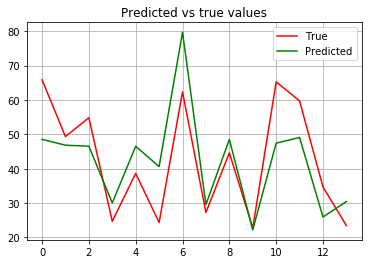

---------------------


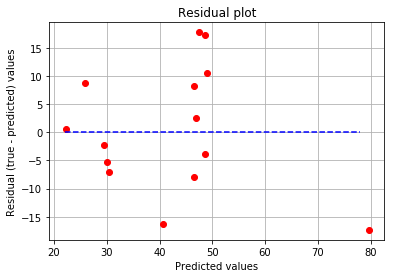

Finished dataset: 228_elusage.tsv
------------------------------------------------------------
Processing dataset: 485_analcatdata_vehicle.tsv


ValueError: k should be >=0, <= n_features; got 5.Use k='all' to return all features.

In [7]:
import sys
import time
import pandas as pd
from sklearn import model_selection
from sklearn import tree, linear_model, svm, ensemble, metrics, cluster
import xgboost as xgb
from matplotlib import pyplot as plt
import scipy
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import *
from skrebate import ReliefF, SURF, TuRF, SURFstar
from sklearn.decomposition import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

start_time = time.time()
datasets = ["228_elusage.tsv", "485_analcatdata_vehicle.tsv", "523_analcatdata_neavote.tsv", \
            '663_rabe_266.tsv', '687_sleuth_ex1605.tsv']


regressor = Pipeline([
  #('preprocessing1', preprocessing.RobustScaler()),
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', svm.NuSVR())
])


parameters = [{'feature_selection__k': [1, 2, 3, 4, 5, 8, 15], \
    'regression__nu':[0.001, 0.005, 0.01, 0.1, 0.5, .1], \
    'regression__C':[0.01, 0.1, 0.05, 1, 2, 5, 10, 50, 100], \
    #'regression__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], \
    #'regression__degree':[2, 3, 4, 5], \
    #'regression__gamma':[0.01, 0.1, 0.05, 'auto'], \
    #'regression__coef0':[00.0, .01, 0.1, 0.05, 1, 2, 5, 10, 50, 100], \
    #'regression__shrinking':[True, False], \
    #'regression__toI':[0.0001, 0.01, 0.1, 0.5, 1, 2], \
}]


print('Training started...')
dataset_accuracies = list()
r2_scores = list()
for d_set in datasets:
    print("Processing dataset: %s" % d_set)
    data_path = "data/" + d_set
    df = pd.read_csv(data_path, sep="\t")
    label = df["target"].copy()
    data = df.drop("target", axis=1)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, test_size=0.25, random_state=42)
    
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    optimized_regressor = GridSearchCV(regressor, parameters, cv=5, error_score=0)
    
    optimized_regressor.fit(X_train, y_train)
    best_regressor = optimized_regressor.best_estimator_
    best_result = optimized_regressor.cv_results_
    
    print(optimized_regressor.best_params_)
    prediction = best_regressor.predict(X_test)
    
    r2_square = metrics.r2_score(y_test, prediction)
    r2_scores.append(r2_square)
    residual = y_test - prediction
    print("R-square score: %0.2f" % r2_square)
    
    plt.figure()
    plt.plot(y_test, color='r')
    plt.plot(prediction, color='g')
    plt.grid(True)
    plt.legend(['True', 'Predicted'])
    plt.title('Predicted vs true values')
    plt.show()
    
    print("---------------------")
    
    plt.figure()
    plt.plot(prediction, residual, 'ro')
    max_pred = int(np.max(prediction))
    min_pred = int(np.min(prediction))
    plt.plot(np.arange(min_pred, max_pred), [0 for i in range(max_pred - min_pred)], 'b--')
    plt.grid(True)
    plt.xlabel('Predicted values')
    plt.ylabel('Residual (true - predicted) values')
    plt.title('Residual plot')
    plt.show()
    
    print("Finished dataset: %s" % d_set)
    print("------------------------------------------------------------")

print('Training finished')
print("Mean R2 square: \n", np.mean(r2_scores))
end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))

